In [10]:
import numpy as np
from numpy import pi, sqrt, sin, cos, exp
from scipy.integrate import quad
import strawberryfields as sf
from strawberryfields.ops import *
import sys
sys.path.insert(0, './../dqs/classical')
from classical_evolution import *
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-deep')
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import warnings
warnings.filterwarnings(action='ignore', module='strawberryfields')
from tqdm import tqdm
np.random.seed(42)
sf.hbar = 1


In [11]:
def animate_evolution(xvec, snapshots1, snapshots2=None, label1='First', label2='Second', interval=20):
    fig, ax = plt.subplots()
    lines = []
    ln1, = ax.plot([], [], label=label1)
    if snapshots2 is not None: ln2, = ax.plot([], [], label=label2, color='k', linestyle=':')
    plt.legend(loc='upper right')

    max_val = .05
    for snapshot in snapshots1:
        val = np.max(snapshot)
        if val > max_val:
            max_val = val
    if snapshots2 is not None:
        for snapshot in snapshots2:
            val = np.max(snapshot)
            if val > max_val:
                max_val = val

    def init():
        ax.set_xlim(-L, L)
        ax.set_ylim(-.05, max_val + .05)
        if snapshots2 is not None: return ln1, ln2,
        return ln1,

    def update(frame):
        ln1.set_data(xvec, snapshots1[frame])
        if snapshots2 is not None: ln2.set_data(xvec, snapshots2[frame])
        if snapshots2 is not None: return ln1, ln2,
        return ln1,

    ani = FuncAnimation(fig, update, frames=list(range(len(snapshots1))),
                        init_func=init, blit=True, interval=interval)
    return ani


# Trotterized Hamiltonian

In [12]:
def trotterized_hamiltonian(coeffs, dt, xvec, pvec, K, x0, p0, eng, squeeze=0, return_p_quad=False):
    prog = sf.Program(2) #include an extra ancilla qumode to compute the quartic term
    with prog.context as q:
        def initial_state(p0):
            # Initialize state
            Vac | q[0] #initial vacuum state
            Xgate(x0) | q[0] #displace q by x0
            Zgate(p0) | q[0] #displace p by p0
            Sgate(squeeze) | q[0] #squeeze (phase angle zero)

        def custom_1(k, s): #\#_k(s) in the notes
            Fouriergate() | q[k]
            Vgate(-s) | q[k]
            Fouriergate().H | q[k]

        def custom_2(j, k, s): #G_jk in the notes
            Vgate(3*s/4) | q[j]
            custom_1(k, -s)
            CZgate(1) | (q[j], q[k])
            custom_1(k, s)
            CZgate(-1) | (q[j], q[k])
            custom_1(k, -s)
            CZgate(-1) | (q[j], q[k])
            custom_1(k, s)
            CZgate(1) | (q[j], q[k])

        def quartic(j, k, alpha):
            Fouriergate() | q[k]
            custom_2(j, k, -2*alpha)
            Fouriergate().H | q[k]
            Pgate(-2*alpha) | q[k]
            custom_2(j, k, -1)
            Pgate(2*alpha) | q[k]
            custom_2(j, k, 1)

        def kinetic_step(dt):
            # Time step
            Fouriergate() | q[0]
            Pgate(-dt) | q[0]
            Fouriergate().H | q[0]

        def potential_step(coeffs, dt):
            Pgate(-2*coeffs[0]*dt) | q[0] #quadratic term
            Vgate(-3*coeffs[1]*dt) | q[0] #cubic term
            quartic(0, 1, -coeffs[2]*dt) #quartic term

        initial_state(p0)
        for _ in range(K):
            kinetic_step(dt)
            potential_step(coeffs, dt)

    result = eng.run(prog, shots=1)
    if return_p_quad: return result.state.p_quad_values(0, xvec, pvec)
    return result.state.x_quad_values(0, xvec, pvec)


# Solution at Final Time

In [13]:
coeffs = [9/2, .5/6, .1/24]
x0 = 1
p0 = 0
squeeze = 0
K = 20
dt = .001
L = 20
xvec, pvec = np.linspace(-L, L, 500), 10*np.linspace(-L, L, 500)
xpvec, xpvec = pvec.copy(), 10*pvec.copy()
tvec = np.arange(0, dt*K, dt)


working on time evolution: 100%|██████████| 20/20 [00:00<00:00, 5895.02it/s]

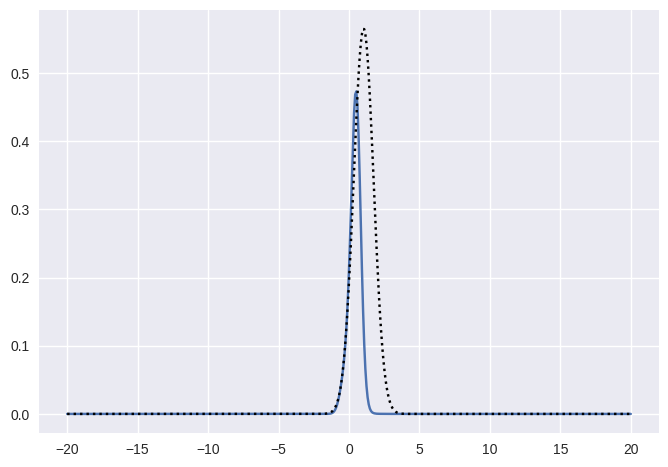

In [14]:
potential = lambda x: coeffs[0]*x**2 + coeffs[1]*x**3 + coeffs[2]*x**4
def initial_wave_function(x):
    sigma = 1
    val = 1/pi**(1/4)*np.exp(-(x - x0)**2 / (2 * sigma**2))
    return val
states, t_grid, x_grid = time_evolve_2(potential, initial_wave_function, len(xvec), L, K, T=dt*K, f=lambda x: 0)
bench = np.abs(states[-1])**2
result = trotterized_hamiltonian(coeffs, dt, xvec, pvec, K, x0, p0, sf.Engine('fock', backend_options={"cutoff_dim": 30}), squeeze=squeeze)

plt.plot(xvec, result)
plt.plot(xvec, bench, ':k')


# Animations

In [7]:
# trotter_ham_snapshots = []
# progress = tqdm(total=K)
# for k in range(K):
#     result2 = trotterized_hamiltonian(coeffs, dt, xvec, pvec, k, x0, p0, sf.Engine('fock', backend_options={"cutoff_dim": 20}), squeeze=squeeze)
#     trotter_ham_snapshots.append(result2)
#     progress.update(1)

# progress.close()


In [8]:
potential = lambda x: coeffs[0]*x**2 + coeffs[1]*x**3 + coeffs[2]*x**4
def initial_wave_function(x):
    sigma = 1
    val = 1/pi**(1/4)*np.exp(-(x - x0)**2 / (2 * sigma**2))
    return val
states, t_grid, x_grid = time_evolve_2(potential, initial_wave_function, len(xvec), L, 1000, T=2, f=lambda x: 0)
exact_ham_snapshots = np.abs(states)**2


working on time evolution: 100%|██████████| 1000/1000 [00:00<00:00, 5302.23it/s]


In [9]:
anim = animate_evolution(xvec, snapshots1=exact_ham_snapshots, label1='Classical Solution', interval=20)
# anim.save('./animations/hamiltonian.gif', writer='ffmpeg')
video = HTML(anim.to_html5_video())
display(video)
plt.close()
